In [45]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

In [46]:
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]

print(f"{len(channels)} channels")

32 channels


In [7]:
# %matplotlib widget

subject = "K309"
sample = "sample1"
sample = f"../data/DataVIN/{'ALS/als-patients' if subject.startswith('ALS') else 'Official'}/{subject}/{sample}"
print(sample)

# ---------------raw and annotation fixing---------------
with open(f"{sample}/eeg.json", mode="r", encoding="utf-8") as f:
    scenario = json.load(f).get("Scenario", "").strip().lower()

# fix scenario's name
if scenario == "nang tay trai":
    scenario = "nâng tay trái"
    
print(scenario)
                    
intention_scenario = scenario in {"tôi muốn uống nước", "tôi muốn vệ sinh"}
                
raw = mne.io.read_raw_edf(f"{sample}/EEG.edf", preload=True, verbose=False)
raw.set_montage("standard_1020")

raw.pick_channels(ch_names=channels, ordered=True)

df = pd.DataFrame(raw.annotations)
df["onset (1)"] = df["onset"].apply(lambda x: timedelta(seconds=x))
df["offset (1)"] = df.apply(lambda r: timedelta(seconds=r["onset"] + r["duration"]), axis=1)
print(df)

# raw = raw.crop(tmin=0, tmax=df[df["description"] == "Typing"].iloc[0]["onset"], include_tmax=False)
            
# fix wrong annotation in some subjects
# TODO: double check?
if intention_scenario:
    raw.annotations.description[
        np.where(raw.annotations.description == "Thinking and Acting")[0]
    ] = "Thinking"

if sample.endswith("K312/sample1"):
    # wrong label "Thinking" (2)
    raw.annotations.description[2] = "Thinking and Acting"

elif sample.endswith("K360/sample5"):
    # wrong label "Thinking and Acting" (8)
    raw.annotations.description[8] = "Thinking"

elif sample.endswith("K369/sample6"):
    # wrong label "Thinking and Acting" (8)
    raw.annotations.description[8] = "Thinking"
                
# ---------------ica validation--------------------------
raw = raw.filter(l_freq=8.0, h_freq=30.0, verbose=False)

# list_of_crop = list()
# for _, r in df.iterrows():
#     if r["description"] in {"Thinking and Acting", "Typing"}:
#         continue
    
#     list_of_crop.append(raw.copy().crop(tmin=r["onset"], tmax=r["onset"] + r["duration"], verbose=False))
                        
# raw = mne.concatenate_raws(list_of_crop)
            
# ica = mne.preprocessing.ICA(n_components=len(channels), max_iter=5000, random_state=42, verbose=False)
# ica.fit(raw)
            
# ica.plot_sources(raw, picks=list(range(len(channels))))

../data/DataVIN/Official/K309/sample1
nâng tay trái
      onset  duration          description                 orig_time  \
0    7.6669    7.0473             Thinking 2021-10-18 16:12:21+00:00   
1   14.7153    6.2803              Resting 2021-10-18 16:12:21+00:00   
2   20.9956    8.2471  Thinking and Acting 2021-10-18 16:12:21+00:00   
3   29.2437    5.7646              Resting 2021-10-18 16:12:21+00:00   
4   35.0082    6.1645             Thinking 2021-10-18 16:12:21+00:00   
5   41.1727    5.9817              Resting 2021-10-18 16:12:21+00:00   
6   47.1554    7.2455  Thinking and Acting 2021-10-18 16:12:21+00:00   
7   54.4019    5.3167              Resting 2021-10-18 16:12:21+00:00   
8   59.7186    6.3457             Thinking 2021-10-18 16:12:21+00:00   
9   66.0653    6.3800              Resting 2021-10-18 16:12:21+00:00   
10  72.4462    7.2982  Thinking and Acting 2021-10-18 16:12:21+00:00   
11  79.7444    4.6142              Resting 2021-10-18 16:12:21+00:00   
12  84.3586 

In [8]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Resting', 'Thinking', 'Thinking and Acting', 'Typing']


In [9]:
epochs = mne.Epochs(
    raw,
    events[np.where(events[:, 2] == 2)[0]],
    event_id=event_id,
    tmin=0,
    tmax=4,
    baseline=None,
    preload=True,
    proj=False,
    on_missing="ignore",
    event_repeated="drop",
    verbose=False,
)

    Using multitaper spectrum estimation with 7 DPSS windows


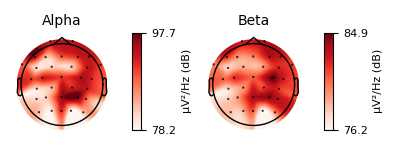

    Using multitaper spectrum estimation with 7 DPSS windows


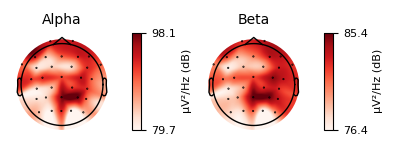

    Using multitaper spectrum estimation with 7 DPSS windows


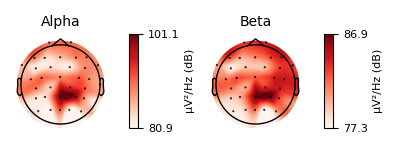

In [11]:
for i in range(len(epochs)):
    epochs[i].plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 30, "Beta")])

In [47]:
%%time
# fmt: off
# subjects = [
#     # 'BN001', 'BN002', 'BN003',
#     # 'BN004', 'BN099', 'BN100',
#     'K001', 'K002', 'K003',
#     'K004', 'K005', 'K006',
#     'K007', 'K008', 'K009',
#     'K010', 'K011', 'K012',
#     'K013', 'K014', 'K015',
#     'K016', 'K017', 'K018',
#     'K019', 'K020', 'K021',
#     'K022', 'K023', 'K024',
#     'K025', 'K026', 'K027',
#     'K028', 'K299', 'K300',
#     'K301', 'K302', 'K303',
#     'K304', 'K305', 'K306',
#     'K307', 'K308', 'K309',
#     'K310', 'K311', 'K312',
#     'K313', 'K314', 'K315',
#     'K316', 'K317', 
#     # 'K318',
#     'K319', 'K320', 'K321',
#     'K322', 'K323', 'K324',
#     'K325', 'K326', 'K327',
#     'K328', 'K329', 'K330',
#     'K331', 'K332', 'K333',
#     'K334', 'K335', 'K336',
#     'K337', 'K338', 'K339',
#     'K340', 'K342', 'K343',
#     'K344', 'K350', 'K351',
#     'K352', 'K353', 'K354',
#     'K355', 
#     # 'K355 (1)', 
#     'K356',
#     'K357', 'K358', 'K359',
#     'K360', 'K361', 'K362',
#     'K363', 'K364', 'K365',
#     'K366', 'K367', 'K368',
#     'K369', 'K370', 'K371',
#     'K372', 'K373', 'K374',
#     'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K008', 'K009', 'K010', 'K012', 
    'K013', 'K015', 'K016', 'K017', 'K021', 
    'K022', 'K023', 'K024', 'K026', 'K027', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K354', 
    'K355', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K364', 'K365', 'K366', 
    'K368', 'K369', 'K370', 'K371', 'K372', 
    'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    # "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    "há miệng_Thinking": "há miệng",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    "rest": 10,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = [
#     'ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'ALS01_t6',
#     'ALS02_t1', 'ALS02_t2', 'ALS02_t3', 'ALS02_t4', 
# ]

# als_ds = load_data(
#     "../data/DataVIN/ALS/als-patients",  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     max_duration=max_duration,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=moving_standardize,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = als_ds
# subjects = als_subjects

# ds = BaseConcatDataset([ds, als_ds])
# subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


trial: 100%|██████████| 1316/1316 [00:04<00:00, 296.83it/s]


loaded 83 subjects - 13574 epochs
CPU times: user 1min 3s, sys: 7.9 s, total: 1min 10s
Wall time: 1min 9s


subject        scenario     event    onset           label  label_idx  \
0       K001   nâng tay trái  Thinking   6.7125   nâng tay trái          5   
1       K001   nâng tay trái  Thinking  37.0182   nâng tay trái          5   
2       K001   nâng tay trái  Thinking  62.7771   nâng tay trái          5   
3       K001  nâng chân trái  Thinking   7.2251  nâng chân trái          3   
4       K001  nâng chân trái  Thinking  35.8373  nâng chân trái          3   
...      ...             ...       ...      ...             ...        ...   
1311    K375         gật đầu  Thinking  26.3047         gật đầu          0   
1312    K375         gật đầu  Thinking  46.0980         gật đầu          0   
1313    K375         lắc đầu  Thinking   6.0130         lắc đầu          1   
1314    K375         lắc đầu  Thinking  24.6901         lắc đầu          1   
1315    K375         lắc đầu  Thinking  44.9166         lắc đầu          1   

      trial  split  epochs  
0         0  train       9  
1         1  train      10  
2         2  train      10  
3         0  train      13  
4         1  train      10  
...     ...    ...     ...  
1311      1  train      10  
1312      2  train      11  
1313      0  train      10  
1314      1  train       9  
1315      2  train      10  

[1316 rows x 9 columns]

In [48]:
ea_ds = deepcopy(ds)

euclidean_alignment(ea_ds, target_subject=None)
# euclidean_alignment(ea_ds, target_subject="K309")

subject: 100%|██████████| 83/83 [00:03<00:00, 23.71it/s]


<AxesSubplot:>

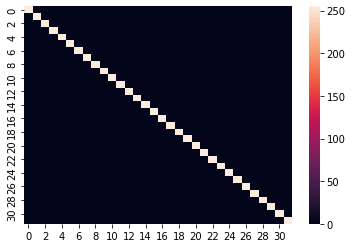

In [42]:
X = list()
for i in ds_info[ds_info["subject"] == "ALS01_t1"].index:
    X.append(ds.datasets[i].windows.get_data())
    
X = np.concatenate(X, axis=0)

sb.heatmap((X @ X.transpose((0, 2, 1))).mean(axis=0))

<AxesSubplot:>

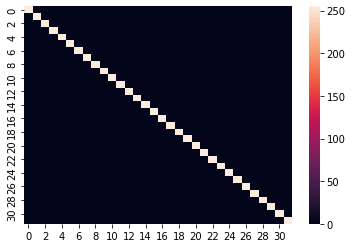

In [43]:
X = list()
for i in ds_info[ds_info["subject"] == "ALS01_t2"].index:
    X.append(ds.datasets[i].windows.get_data())
    
X = np.concatenate(X, axis=0)

sb.heatmap((X @ X.transpose((0, 2, 1))).mean(axis=0))

In [96]:
subds = list()
for i in ds_info[ds_info["subject"] == "K309"].index:
    subds.append(ds.datasets[i])

subds = BaseConcatDataset(subds)
subds_info = subds.description

# freqs = np.arange(14, 31)
    
# for label in subds_info["label"].unique():
#     print(label)
#     epochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[ds_info["label"] == label].index])
        
#     epochs.filter(l_freq=14.0, h_freq=30.0, verbose=False)
        
#     # tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
#     #                                         return_itc=False, average=True, decim=2)
#     # tfr.plot(picks=["C3", "Cz", "C4"], title="auto", mode="logratio")
        
#     # epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 20, "Lower Beta"), (20, 30, "Higher Beta")])
#     epochs.average().plot_topomap(np.arange(0.0, 2.0, 0.2))
#     # fig = epochs.plot_psd()
#     # plt.savefig(f"../data/DataVIN/Official_PSD/{subject}_{label}.png")
#     # plt.close(fig)
#     # break

In [19]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for _ds in ds.datasets:
    # if _ds.description["trial"] == 2:
    #     Xvalid.append(_ds.windows.get_data())
    #     Yvalid.extend(_ds.y)
    # else:
    # if _ds.description["subject"] != "K309":
    #     continue
    if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
        continue
        
    Xtrain.append(_ds.windows.get_data())
    Ytrain.extend(_ds.y)
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
# Xvalid = np.concatenate(Xvalid, axis=0)
# Yvalid = np.array(Yvalid, dtype=int)

# Xtrain.shape, Xvalid.shape

In [20]:
# -------------csp-------------
csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')
    
Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
# Xvalid_csp = csp.transform(Xvalid)

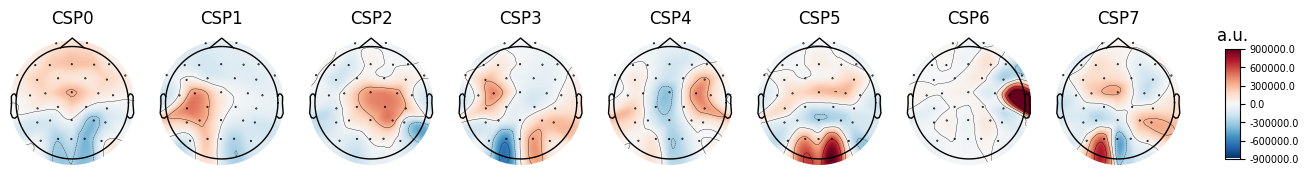

In [21]:
for i in range(0, 32, 8):
    csp.plot_patterns(ds.datasets[0].windows.info, components=list(range(i, i + 8)))

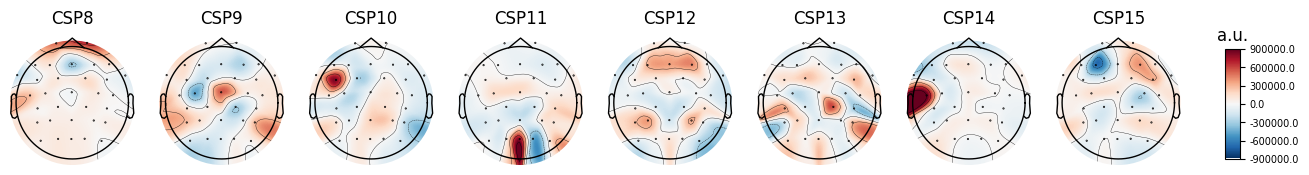

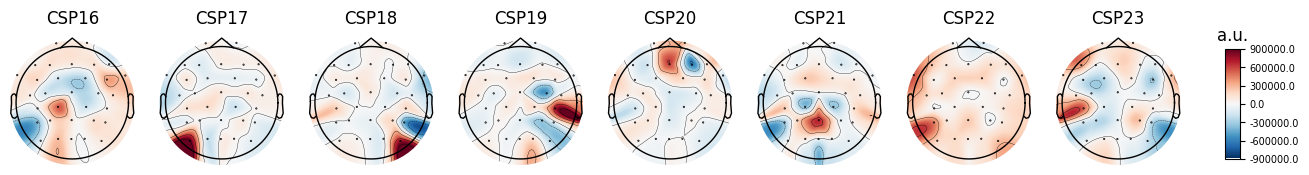

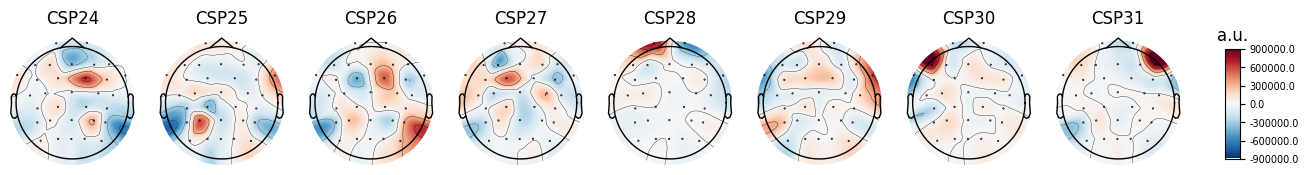

In [22]:
for i in range(0, 32, 8):
    csp.plot_filters(ds.datasets[0].windows.info, components=list(range(i, i + 8)))

In [148]:
max_acc = 0
for nc in range(1, 33):
#     # -------------csp-------------
#     csp = mne.decoding.CSP(n_components=nc, reg=None, log=None, transform_into='csp_space')
    
#     Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
#     Xvalid_csp = csp.transform(Xvalid)
    
    # ------------band power-------
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
    # bands = [(8,12), (12,16)]
    # bands = [(8,12), (12,16), (16,20)]
    # bands = [(20,24), (24,28), (28, 32)]
    # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })

    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

    Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
    Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])
    
    # ------------csv--------------
    clf = SVC(
        C=0.1,
        kernel="rbf",
        # tol=1e-7,
        max_iter=100000,
        class_weight="balanced",
        random_state=42,
    )

    clf.fit(Xtrain_bp, Ytrain)
    
    Ypred = clf.predict(Xvalid_bp)
    acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
    
    if acc >= max_acc:
        print(f"\033[91mn_components: {nc} - acc: {acc}\033[0m")
        max_acc = acc
    else:
        print(f"n_components: {nc} - acc: {acc}")

n_components: 1 - acc: 0.27838400010647296
n_components: 2 - acc: 0.28558187788551775
n_components: 3 - acc: 0.2928313170879812
n_components: 4 - acc: 0.3004237594194663
n_components: 5 - acc: 0.29782213191495593
n_components: 6 - acc: 0.3110650885518347
n_components: 7 - acc: 0.33244275205520024
n_components: 8 - acc: 0.3292042826719598
n_components: 9 - acc: 0.3340091232435877
n_components: 10 - acc: 0.3318261695145635
n_components: 11 - acc: 0.3343980479033237
n_components: 12 - acc: 0.3339863274995753
n_components: 13 - acc: 0.3323381243117936
n_components: 14 - acc: 0.33803308014093486
n_components: 15 - acc: 0.336854182582194
n_components: 16 - acc: 0.3423073745560743
n_components: 17 - acc: 0.348373293544249
n_components: 18 - acc: 0.3532408194949752
n_components: 19 - acc: 0.3532841536619092
n_components: 20 - acc: 0.35459387471713755
n_components: 21 - acc: 0.3525291142540849
n_components: 22 - acc: 0.3531020864515783
n_components: 23 - acc: 0.35608909143159395
n_components: 2

In [170]:
# ------------band power-------
bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]  # 0.35999104324195197
# bands = [(8,12), (12,16)]  # 0.32153481896849656
# bands = [(8,12), (12,16), (16,20)]  # 0.3483254957167577
# bands = [(16, 20), (20,24), (24,28), (28, 32)]  # 0.29867913557453657
# bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]  # 0.3152607889922439
# bands = [(8,12), (12,16), (16,20), (20,24)]  # 0.3489478712232937
# bands = [(8,12), (12,16), (16,20), (20,24), (24,28)]  # 0.3510230577493549
# bands = [(8,12), (12,16), (16,20), (20,24), (24,30)]  # 0.35821080917669934

nc = 32

params = dict({
    'pow_freq_bands__log': True,
    'pow_freq_bands__normalize': False,
    'pow_freq_bands__freq_bands': bands,
})

fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])
    
# ------------csv--------------
clf = SVC(
    C=1.0,
    kernel="rbf",
    # tol=1e-7,
    max_iter=100000,
    class_weight="balanced",
    random_state=42,
)

clf.fit(Xtrain_bp, Ytrain)
    
Ypred = clf.predict(Xvalid_bp)
print(metrics.balanced_accuracy_score(Yvalid, Ypred))
print(metrics.confusion_matrix(Yvalid, Ypred))

0.3697923804040626
[[421 214 111 115  46  63]
 [203 303  86  78  36  34]
 [139 127 273 112  64  25]
 [205 108 171 291 135  84]
 [ 71  54 101 165 242 107]
 [121  40  55 171 216 380]]


In [185]:
x0 = Xtrain[0, 0]
plt.plot(range(256), x0)

for i in range(8, 30, 4):
    b, a = signal.butter(N=5, Wn=[i,i+4], btype="bandpass", fs=128.0)
    xf = signal.filtfilt(b, a, x0)

    plt.plot(range(256), xf)

In [237]:
subds = list()
for i in ds_info[ds_info["subject"] == "K310"].index:
    subds.append(ds.datasets[i])

subds = BaseConcatDataset(subds)
subds_info = subds.description

In [238]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for _ds in subds.datasets:
    if _ds.description["trial"] == 2:
        Xvalid.append(_ds.windows.get_data())
        Yvalid.extend(_ds.y)
    else:
        if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
            continue
        
        Xtrain.append(_ds.windows.get_data())
        Ytrain.extend(_ds.y)
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

Xtrain.shape, Xvalid.shape

((245, 32, 256), (128, 32, 256))

In [239]:
# -------------csp-------------
csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')
    
Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
Xvalid_csp = csp.transform(Xvalid)

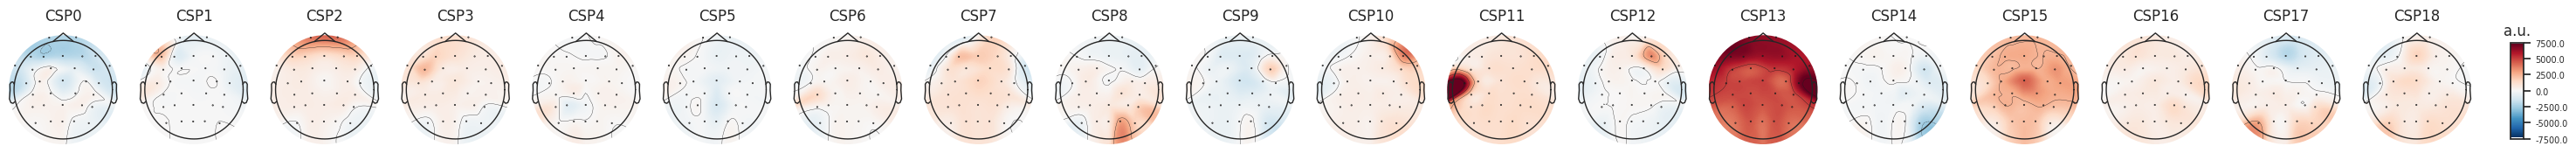

In [240]:
csp.plot_patterns(ds.datasets[0].windows.info, components=list(range(19)))

In [6]:
result = list()

for subject in ds_info["subject"].unique():
    print(f"subject {subject}")
    
    # -------load data----------
    subds = list()
    for i in ds_info[ds_info["subject"] == subject].index:
        subds.append(ds.datasets[i])

    subds = BaseConcatDataset(subds)
    subds_info = subds.description
    
    list_of_acc = list()
    for fold in range(3):
        Xtrain = list()
        Ytrain = list()
        Xvalid = list()
        Yvalid = list()
        for _ds in subds.datasets:
            if _ds.description["trial"] == fold:
                Xvalid.append(_ds.windows.get_data())
                Yvalid.extend(_ds.y)
            else:
                if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
                    continue

                Xtrain.append(_ds.windows.get_data())
                Ytrain.extend(_ds.y)

        Xtrain = np.concatenate(Xtrain, axis=0)
        Ytrain = np.array(Ytrain, dtype=int)
        Xvalid = np.concatenate(Xvalid, axis=0)
        Yvalid = np.array(Yvalid, dtype=int)

        # -------------csp-------------
        csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')

        Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
        Xvalid_csp = csp.transform(Xvalid)

        # -------------training--------
        max_acc = 0
        for nc in range(1, 33):
        #     # -------------csp-------------
        #     csp = mne.decoding.CSP(n_components=nc, reg=None, log=None, transform_into='csp_space')

        #     Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
        #     Xvalid_csp = csp.transform(Xvalid)

            # ------------band power-------
            bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
            # bands = [(8,12), (12,16)]
            # bands = [(8,12), (12,16), (16,20)]
            # bands = [(20,24), (24,28), (28, 32)]
            # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

            params = dict({
                'pow_freq_bands__log': True,
                'pow_freq_bands__normalize': False,
                'pow_freq_bands__freq_bands': bands,
            })

            fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

            Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
            Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])

            # ------------csv--------------
            clf = SVC(
                C=1.0,
                kernel="rbf",
                # tol=1e-7,
                max_iter=100000,
                class_weight="balanced",
                random_state=42,
            )

            clf.fit(Xtrain_bp, Ytrain)

            Ypred = clf.predict(Xvalid_bp)
            acc = metrics.balanced_accuracy_score(Yvalid, Ypred)

            if acc >= max_acc:
                # print(f"\033[91m\tn_components: {nc} - acc: {acc}\033[0m")
                # print(f"\tn_components: {nc} - acc: {acc}")
                max_acc = acc
            # else:
            #     print(f"\tn_components: {nc} - acc: {acc}")
            
        print(f"subject {subject} - fold: {fold} - acc: {max_acc}")
            
        list_of_acc.append(max_acc)

    result.append((subject, *list_of_acc))

subject ALS03_t1
subject ALS03_t1 - fold: 0 - acc: 0.46156234475906605


/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.w

subject ALS03_t1 - fold: 1 - acc: 0.5233333333333334


/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


subject ALS03_t1 - fold: 2 - acc: 0.5433189033189033


In [10]:
result = pd.DataFrame(result, columns=["subject", "acc1", "acc2", "acc3"])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result)

    subject      acc1      acc2      acc3
0  ALS01_t1  0.543454  0.612738  0.692523
1  ALS01_t2  0.750801  0.889438  0.796157
2  ALS01_t3  0.640900  0.575928  0.550068
3  ALS01_t4  0.662555  0.884422  0.727462
4  ALS01_t5  0.615789  0.865038  0.842729
5  ALS01_t6  0.683669  0.775337  0.789002
6  ALS02_t1  0.539522  0.699423  0.731612
7  ALS02_t2  0.658086  0.814635  0.780165
8  ALS02_t3  0.600549  0.747137  0.743204
9  ALS02_t4  0.543518  0.760061  0.507068


/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='acc', ylabel='Density'>

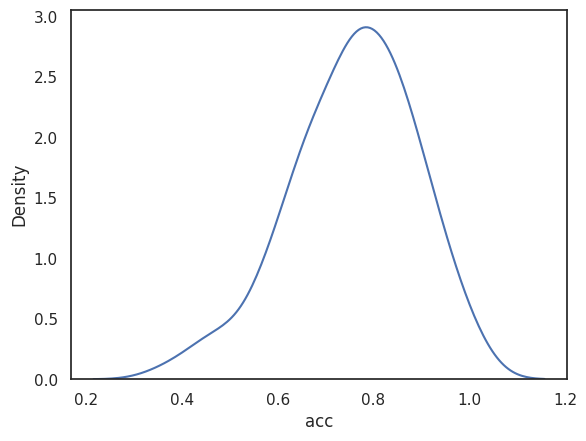

In [246]:
sb.distplot(result["acc"], hist=False)

In [254]:
print(result[result["acc"] >= 0.7].sort_values("acc", ascending=False)["subject"].tolist())

['K008', 'K016', 'K007', 'K001', 'K022', 'K323', 'K021', 'K309', 'K013', 'K321', 'K337', 'K304', 'K004', 'K027', 'K326', 'K312', 'K335', 'K369', 'K025', 'K012', 'K320', 'K023', 'K327', 'K372', 'K374', 'K305', 'K313', 'K017', 'K339', 'K306', 'K328', 'K336', 'K362', 'K359', 'K311', 'K006', 'K307', 'K316', 'K358', 'K018', 'K011', 'K371', 'K332', 'K303', 'K373', 'K322', 'K370', 'K368', 'K315', 'K375', 'K360', 'K324', 'K366', 'K015', 'K329', 'K365', 'K302', 'K308', 'K325', 'K340', 'K024', 'K005', 'K009', 'K357']


In [264]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for _ds in ds.datasets:
    # if _ds.description["trial"] == 2:
    #     Xvalid.append(_ds.windows.get_data())
    #     Yvalid.extend(_ds.y)
    if _ds.description["subject"] == "K309":
        Xvalid.append(_ds.windows.get_data())
        Yvalid.extend(_ds.y)
    
    else:
        if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
            continue

        Xtrain.append(_ds.windows.get_data())
        Ytrain.extend(_ds.y)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

Xtrain.shape, Xvalid.shape

((17091, 32, 256), (516, 32, 256))

In [265]:
# -------------csp-------------
csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')

Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
Xvalid_csp = csp.transform(Xvalid)
    
# -------------training--------
max_acc = 0
for nc in range(1, 33):
#     # -------------csp-------------
#     csp = mne.decoding.CSP(n_components=nc, reg=None, log=None, transform_into='csp_space')

#     Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
#     Xvalid_csp = csp.transform(Xvalid)

    # ------------band power-------
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
    # bands = [(8,12), (12,16)]
    # bands = [(8,12), (12,16), (16,20)]
    # bands = [(20,24), (24,28), (28, 32)]
    # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })

    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

    Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
    Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])

    # ------------csv--------------
    clf = SVC(
        C=0.1,
        kernel="rbf",
        # tol=1e-7,
        max_iter=100000,
        class_weight="balanced",
        random_state=42,
    )

    clf.fit(Xtrain_bp, Ytrain)

    Ypred = clf.predict(Xvalid_bp)
    acc = metrics.balanced_accuracy_score(Yvalid, Ypred)

    if acc >= max_acc:
        print(f"\033[91m\tn_components: {nc} - acc: {acc}\033[0m")
        # print(f"\tn_components: {nc} - acc: {acc}")
        max_acc = acc
    else:
        print(f"\tn_components: {nc} - acc: {acc}")

	n_components: 1 - acc: 0.34591939619162854
	n_components: 2 - acc: 0.3968023507043471
	n_components: 3 - acc: 0.4076013789262428
	n_components: 4 - acc: 0.3779554249608696
	n_components: 5 - acc: 0.3493955194499659
	n_components: 6 - acc: 0.3483901324191705
	n_components: 7 - acc: 0.3234974409203084
	n_components: 8 - acc: 0.3519824465378004
	n_components: 9 - acc: 0.38478379857690204
	n_components: 10 - acc: 0.40904944353220213
	n_components: 11 - acc: 0.38062589423750953
	n_components: 12 - acc: 0.37044527026378204
	n_components: 13 - acc: 0.4764315002064548
	n_components: 14 - acc: 0.46229366519747644
	n_components: 15 - acc: 0.4370447190773869
	n_components: 16 - acc: 0.4332296257886094
	n_components: 17 - acc: 0.4370447190773869
	n_components: 18 - acc: 0.4086518979440939
	n_components: 19 - acc: 0.4428206531654807
	n_components: 20 - acc: 0.4471648469833588
	n_components: 21 - acc: 0.4473290505958382
	n_components: 22 - acc: 0.4628150836862271
	n_components: 23 - acc: 0.44614313

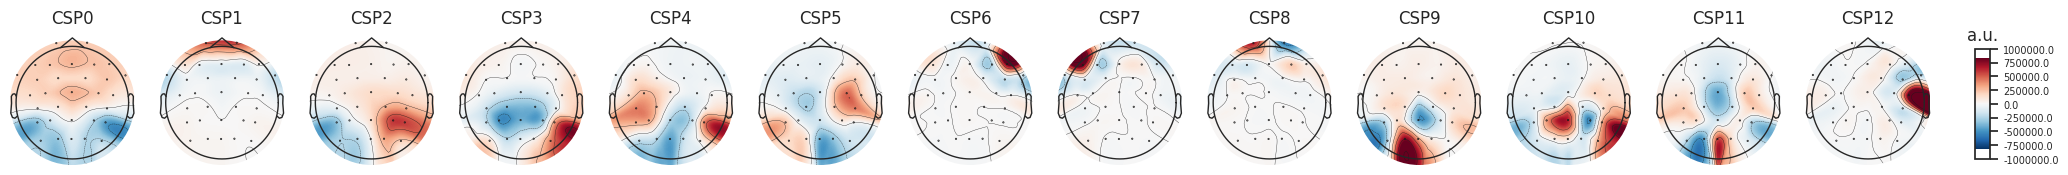

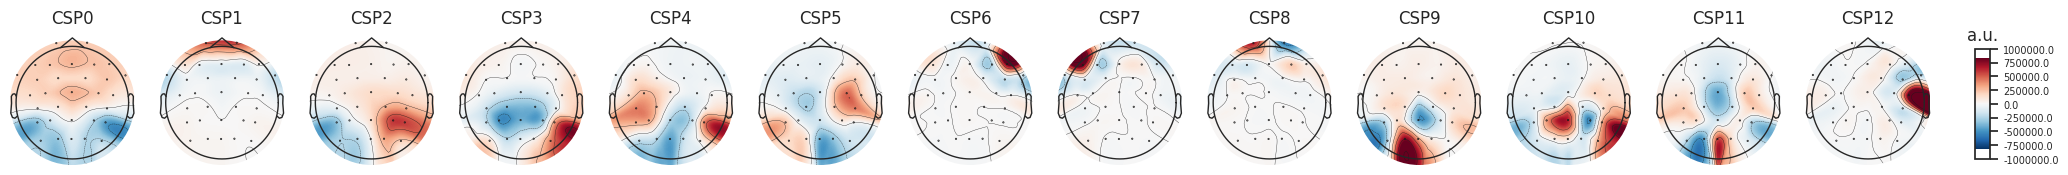

In [266]:
# n_components: 11 - acc: 0.544274159216688
csp.plot_patterns(ds.datasets[0].windows.info, components=list(range(13)))

In [50]:
from collections import defaultdict

data = defaultdict(list)
with open("./csp_psd_svm.txt", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line.rfind(":") == -1:
            continue
            
        subj, fold, acc = line.split("-")
        subj = subj.strip().split()[-1]
        fold = int(fold.strip().split()[-1])
        acc = float(acc.strip().split()[-1])
        
        data[subj].append((fold, acc))

In [51]:
result = list()
for k, v in data.items():
    accs = [0] * 3
    for f, a in v:
        accs[f] = a
        
    result.append((k, *accs))

result = pd.DataFrame(result, columns=["subject", "acc1", "acc2", "acc3"])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result)

      subject      acc1      acc2      acc3
0        K001  0.806856  1.000000  0.972222
1        K002  0.621528  0.561806  0.591880
2        K003  0.541667  0.640972  0.596825
3        K004  0.867045  0.850899  0.909722
4        K005  0.595328  0.708819  0.735795
5        K006  0.826389  0.900568  0.805556
6        K007  0.491259  0.861111  0.991667
7        K008  0.900000  0.899209  1.000000
8        K009  0.715503  0.673099  0.727273
9        K010  0.715385  1.000000  0.686508
10       K011  0.830460  0.490476  0.791667
11       K012  0.944444  0.825000  0.869048
12       K013  0.583333  0.750000  0.922222
13       K014  0.593750  0.600000  0.462963
14       K015  0.725000  0.769544  0.750000
15       K016  0.865302  0.805556  1.000000
16       K017  0.870536  0.925000  0.838889
17       K018  0.468750  0.703704  0.792593
18       K020  0.503846  0.678535  0.372382
19       K021  0.891964  0.812500  0.928571
20       K022  0.897222  0.990000  0.954545
21       K023  0.726190  0.88888

<AxesSubplot:xlabel='acc3', ylabel='Density'>

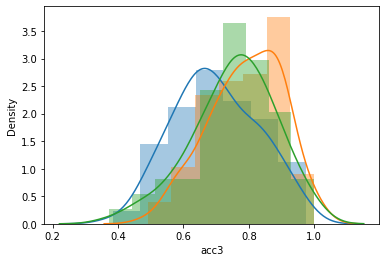

In [52]:
sb.distplot(result["acc1"])
sb.distplot(result["acc2"])
sb.distplot(result["acc3"])

In [53]:
result["min_acc"] = result.apply(lambda r: min(r["acc1"], r["acc2"], r["acc3"]), axis=1)
result["max_acc"] = result.apply(lambda r: max(r["acc1"], r["acc2"], r["acc3"]), axis=1)

<AxesSubplot:xlabel='max_acc', ylabel='Density'>

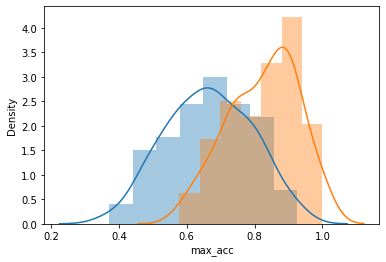

In [54]:
sb.distplot(result["min_acc"])
sb.distplot(result["max_acc"])

In [82]:
len(result[result["min_acc"] >= 0.6])

70

In [92]:
print([x for x in sorted(result[result["min_acc"] >= 0.50]["subject"]) if not x.startswith("ALS")])

['K001', 'K002', 'K003', 'K004', 'K005', 'K006', 'K008', 'K009', 'K010', 'K012', 'K013', 'K015', 'K016', 'K017', 'K021', 'K022', 'K023', 'K024', 'K026', 'K027', 'K300', 'K301', 'K302', 'K303', 'K304', 'K305', 'K306', 'K307', 'K308', 'K309', 'K310', 'K311', 'K312', 'K313', 'K314', 'K315', 'K316', 'K319', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K331', 'K332', 'K333', 'K334', 'K335', 'K336', 'K337', 'K338', 'K339', 'K342', 'K343', 'K344', 'K350', 'K351', 'K352', 'K354', 'K355', 'K357', 'K358', 'K359', 'K360', 'K361', 'K362', 'K364', 'K365', 'K366', 'K368', 'K369', 'K370', 'K371', 'K372', 'K373', 'K374', 'K375']


In [79]:
subjects = {
    # 'ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'ALS01_t6', 
    # 'ALS02_t1', 'ALS02_t2', 'ALS02_t3', 'ALS02_t4', 
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K008', 'K009', 'K010', 'K012', 
    'K013', 'K015', 'K016', 'K017', 'K021', 
    'K022', 'K023', 'K024', 'K026', 'K027', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K354', 
    'K355', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K364', 'K365', 'K366', 
    'K368', 'K369', 'K370', 'K371', 'K372', 
    'K373', 'K374', 'K375',
}

subjects = {
    'ALS01_t2', 'ALS01_t6', 
    'K001', 'K004', 'K006', 'K008', 'K009', 'K010', 'K012', 'K015', 'K016', 'K017', 'K021', 'K022', 'K023', 'K024', 'K027', 'K303', 'K306', 'K307', 'K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323', 'K325', 'K326', 'K327', 'K328', 'K332', 'K334', 'K335', 'K336', 'K337', 'K339', 'K354', 'K358', 'K359', 'K360', 'K362', 'K365', 'K366', 'K368', 'K370', 'K372', 'K373', 'K374', 'K375'}

print(len(subjects))

52


In [80]:
test_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    'K313', 'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
}

selected_subjects = sorted(list(test_subjects & subjects))

print(len(selected_subjects))
print(selected_subjects)

32
['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323', 'K325', 'K326', 'K327', 'K328', 'K332', 'K334', 'K335', 'K336', 'K337', 'K339', 'K354', 'K358', 'K359', 'K360', 'K362', 'K365', 'K366', 'K368', 'K370', 'K372', 'K373', 'K374', 'K375']


In [81]:
test_subjects = {
    'K309', 'K311', 'K312', 
    'K313', 'K315', 'K316', 
    'K321', 'K322', 'K323', 
    'K325', 'K326', 'K327', 
    'K328', 'K332', 'K334', 
    'K335', 'K336', 'K337', 
    'K339', 'K354', 'K358', 
    'K359', 'K360', 'K362', 
    'K365', 'K366', 'K368', 
    'K370', 'K372', 'K373', 
    'K374', 'K375',
}

print(len(test_subjects))

32


In [23]:
sample_dir = "../data/DataVIN/ALS/als-patients/ALS03_t1/sample9"

with open(f"{sample_dir}/eeg.json", mode="r", encoding="utf-8") as f:
    print(json.load(f))

raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)

events, event_id = mne.events_from_annotations(raw)
print(event_id)
print(events)

{'Scenario': 'tôi muốn vệ sinh', 'SamplingFrequence': 128, 'EEGchannelNumber': 32}
{'Resting': 1, 'Thinking': 2, 'Typing': 3}
[[1349    0    2]
 [2181    0    1]
 [2889    0    2]
 [3808    0    1]
 [4546    0    2]
 [5476    0    1]
 [5940    0    3]]


In [4]:
test_subjects = {
    "K309",
    # 'K300', 'K309', 'K310', 
    # 'K311', 'K312', 'K313', 
    # 'K314', 'K315', 'K316', 
    # 'K319', 'K320', 'K321', 
    # 'K322', 'K323', 'K324', 
    # 'K325', 'K326', 'K327', 
    # 'K328', 'K329', 'K330', 
    # 'K331', 'K332', 'K333', 
    # 'K334', 'K335', 'K336', 
    # 'K337', 'K338', 'K339', 
    # 'K342', 'K343', 'K344', 
    # 'K350', 'K351', 'K352', 
    # 'K354', 'K355', 'K357', 
    # 'K358', 'K359', 'K360', 
    # 'K361', 'K362', 'K364', 
    # 'K365', 'K366', 'K368', 
    # 'K369', 'K370', 'K371', 
    # 'K372', 'K373', 'K374', 'K375',
}

Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
Xtest = defaultdict(list)
Ytest = defaultdict(list)
for _ds in ds.datasets:
    if _ds.description["subject"] in test_subjects:
        Xtest[_ds.description["subject"]].append(_ds.windows.get_data())
        Ytest[_ds.description["subject"]].extend(_ds.y)
    
    else:
        if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
            continue

        if _ds.description["trial"] == 2:
            Xvalid.append(_ds.windows.get_data())
            Yvalid.extend(_ds.y)
        else:
            Xtrain.append(_ds.windows.get_data())
            Ytrain.extend(_ds.y)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

print(f"Xtrain: {Xtrain.shape} - Xvalid: {Xvalid.shape}")

print("Xtest:")
for k, v in Xtest.items():
    Xtest[k] = np.concatenate(v, axis=0)
    Ytest[k] = np.array(Ytest[k], dtype=int)
    
    print(f"subject {k}: {Xtest[k].shape}")

Xtrain: (8860, 32, 256) - Xvalid: (4540, 32, 256)
Xtest:
subject K309: (174, 32, 256)


In [5]:
sb.heatmap(Xtrain[0] @ Xtrain[0].T)

<AxesSubplot:>

In [6]:
# -------------csp-------------
csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')

Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
Xvalid_csp = csp.transform(Xvalid)
Xtest_csp = {k: csp.transform(v) for k, v in Xtest.items()}
    
# -------------training--------
max_acc = {k: 0 for k in Xtest.keys()}
max_acc_valid = 0
for nc in range(1, 33):
#     # -------------csp-------------
#     csp = mne.decoding.CSP(n_components=nc, reg=None, log=None, transform_into='csp_space')

#     Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
#     Xvalid_csp = csp.transform(Xvalid)

    # ------------band power-------
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
    # bands = [(8,12), (12,16)]
    # bands = [(8,12), (12,16), (16,20)]
    # bands = [(20,24), (24,28), (28, 32)]
    # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })

    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

    Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
    Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])
    Xtest_bp = {k: fe.transform(v[:, :nc]) for k, v in Xtest_csp.items()}

    # ------------svc--------------
    clf = SVC(
        C=0.1,
        kernel="rbf",
        # tol=1e-7,
        max_iter=100000,
        class_weight="balanced",
        random_state=42,
    )

    clf.fit(Xtrain_bp, Ytrain)
    
    Ypred = clf.predict(Xvalid_bp)
    acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
    
    if acc >= max_acc_valid:
        print(f"\033[91mn_components: {nc} - valid acc: {acc}\033[0m")
        max_acc_valid = acc
    else:
        print(f"n_components: {nc} - valid acc: {acc}")

    for k, v in Xtest_bp.items():
        Ypred = clf.predict(v)
        acc = metrics.balanced_accuracy_score(Ytest[k], Ypred)
        
        if acc >= max_acc[k]:
            print(f"\033[91mn_components: {nc} - subject: {k} - acc: {acc}\033[0m")
            max_acc[k] = acc
        else:
            print(f"n_components: {nc} - subject: {k} - acc: {acc}")
            
    print("-" * 50)

n_components: 1 - valid acc: 0.20471661701041774
n_components: 1 - subject: K309 - acc: 0.31877394636015327
--------------------------------------------------
n_components: 2 - valid acc: 0.21395332450536486
n_components: 2 - subject: K309 - acc: 0.2674329501915709
--------------------------------------------------
n_components: 3 - valid acc: 0.2195624883242031
n_components: 3 - subject: K309 - acc: 0.22911877394636015
--------------------------------------------------
n_components: 4 - valid acc: 0.21171850710350107
n_components: 4 - subject: K309 - acc: 0.19444444444444445
--------------------------------------------------
n_components: 5 - valid acc: 0.22703738897556613
n_components: 5 - subject: K309 - acc: 0.20498084291187738
--------------------------------------------------
n_components: 6 - valid acc: 0.2257047068391619
n_components: 6 - subject: K309 - acc: 0.15440613026819924
--------------------------------------------------
n_components: 7 - valid acc: 0.22450648501025525


In [9]:
nc = 32

# ------------band power-------
bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
# bands = [(8,12), (12,16)]
# bands = [(8,12), (12,16), (16,20)]
# bands = [(20,24), (24,28), (28, 32)]
# bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

params = dict({
    'pow_freq_bands__log': True,
    'pow_freq_bands__normalize': False,
    'pow_freq_bands__freq_bands': bands,
})

fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
Xtest_bp = {k: fe.transform(v[:, :nc]) for k, v in Xtest_csp.items()}

In [10]:
# ------------svc--------------
clf = SVC(
    C=0.1,
    kernel="rbf",
    # tol=1e-7,
    max_iter=100000,
    class_weight="balanced",
    random_state=42,
)

clf.fit(Xtrain_bp, Ytrain)

Ypred = clf.predict(Xtest_bp["K309"])
print(metrics.balanced_accuracy_score(Ytest["K309"], Ypred))
print(metrics.confusion_matrix(Ytest["K309"], Ypred))

0.5348233290762027
[[13 11  2  1  1  1]
 [14 13  0  0  0  2]
 [ 0  5 20  5  0  0]
 [ 1  4  4 17  1  0]
 [ 0  1  0 10 16  3]
 [ 6  0  5  2  2 14]]


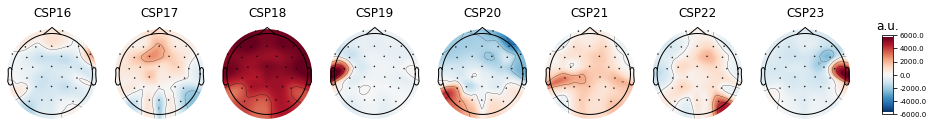

In [7]:
for i in range(0, 32, 8):
    csp.plot_patterns(ds.datasets[0].windows.info, components=list(range(i, min(i + 8, 32))))

In [16]:
csp0 = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')
csp0.fit(Xtest["K309"], Ytest["K309"])

CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=None, n_components=32, norm_trace=False, rank=None, reg=None,
  transform_into='csp_space')

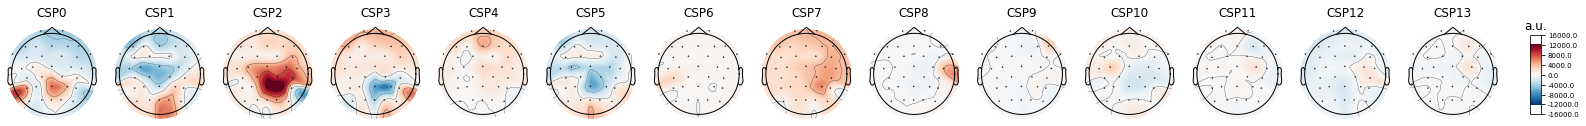

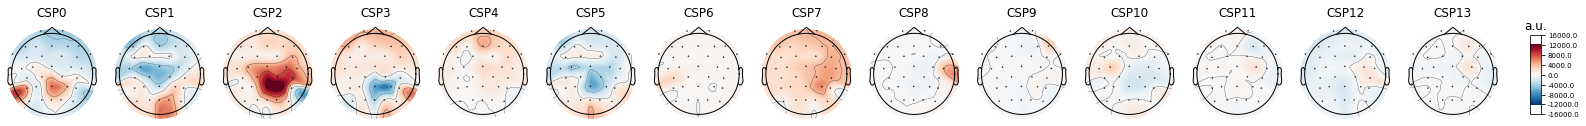

In [18]:
csp0.plot_patterns(ds.datasets[0].windows.info, components=list(range(14)))

In [37]:
ds.datasets[0].windows.event_id

{'gật đầu': 0,
 'lắc đầu': 1,
 'nâng chân phải': 2,
 'nâng chân trái': 3,
 'nâng tay phải': 4,
 'nâng tay trái': 5}

In [13]:
color = "kbgrcmy"

s = "K309"
x = Xvalid_csp[s]
y = Yvalid[s]
labels = ["gật đầu", "lắc đầu", "nâng chân phải", "nâng chân trái", "nâng tay phải", "nâng tay trái"]

for i in range(nc):
    plt.figure(figsize=(8, 4))
    
    max_psd = 0
    max_freq = 0
    for c in range(6):
        freqs, psd = signal.welch(x[np.where(y == c)[0], i][0], fs=128.0, window='hann', nperseg=128, noverlap=64, nfft=None)
        # freqs, psd = signal.welch(x[np.where(y == c)[0], i].mean(axis=0), fs=128.0, window='hann', nperseg=128, noverlap=64, nfft=None)
        max_psd = max(max_psd, psd.max())
        max_freq = max(max_freq, freqs.max())
        
        plt.plot(freqs, psd, color=color[c])
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, max_psd * 1.1])
    plt.title(f"Welch's periodogram CSP{i}")
    plt.xlim([0, max_freq])
    plt.legend(labels)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [11]:
%%time
list_of_subject = sorted(ds_info["subject"].unique())

results = list()
for subject in tqdm(list_of_subject, desc="subject"):
    # print(f"subject {subject}: {len(ds_info[ds_info['subject'] == subject]['label'].unique())} labels")
    
    subject_ds_info = ds_info[ds_info["subject"] == subject]
    n_subject_labels = len(subject_ds_info["label"].unique())
    
    # ----------------load train data--------------------
    Xtrain = list()
    Ytrain = list()
    for i in subject_ds_info.index:
        Xtrain.append(ds.datasets[i].windows.get_data())
        Ytrain.extend(ds.datasets[i].y)
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    
    # ----------------train csp-----------------------------
    csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')

    Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
    
    # ----------------train svc-----------------------------
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
    # bands = [(8,12), (12,16)]
    # bands = [(8,12), (12,16), (16,20)]
    # bands = [(20,24), (24,28), (28, 32)]
    # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })
    
    fe = dict()
    clf = dict()
    for nc in range(1, 33):
        # ------------bandpower extraction------------------
        fe[nc] = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)
        
        Xtrain_bp = fe[nc].fit_transform(Xtrain_csp[:, :nc])
        
        # ------------train svc-----------------------------
        clf[nc] = SVC(
            C=0.1,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        )

        clf[nc].fit(Xtrain_bp, Ytrain)
    
    for target_subject in list_of_subject:
        if target_subject == subject:
            continue

        target_subject_ds_info = ds_info[ds_info["subject"] == target_subject]
        if n_subject_labels < len(target_subject_ds_info["label"].unique()):
            continue
            
        # print(f"subject {subject} ----> target_subject {target_subject}.....")
            
        # ----------------load valid data------------------
        Xvalid = list()
        Yvalid = list()
        for i in target_subject_ds_info.index:
            Xvalid.append(ds.datasets[i].windows.get_data())
            Yvalid.extend(ds.datasets[i].y)
        Xvalid = np.concatenate(Xvalid, axis=0)
        Yvalid = np.array(Yvalid, dtype=int)
        
        # ----------------validate on target subject-------
        Xvalid_csp = csp.transform(Xvalid)
        
        max_acc = 0
        for nc in range(1, 33):
            Xvalid_bp = fe[nc].transform(Xvalid_csp[:, :nc])
            
            Ypred = clf[nc].predict(Xvalid_bp)
            acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
            if acc > max_acc:
                max_acc = acc
                
        results.append((subject, target_subject, max_acc))
        # print(f"subject {subject} ----> target_subject {target_subject}: {max_acc}")
        
    # break

subject: 100%|██████████| 83/83 [5:25:57<00:00, 235.63s/it]  

CPU times: user 5h 7min 25s, sys: 59min 32s, total: 6h 6min 57s
Wall time: 5h 25min 57s


In [12]:
# results = list()
# with open("cross_als_subjects.txt", mode="r", encoding="utf-8") as f:
#     for line in f:
#         x = line.strip().split()
#         results.append((x[1].strip(), x[4].strip()[:-1], float(x[-1].strip())))
        
results = pd.DataFrame(results, columns=["subject", "target_subject", "acc"])

results

subject target_subject       acc
0       K001           K002  0.397436
1       K001           K003  0.439560
2       K001           K004  0.333333
3       K001           K005  0.424731
4       K001           K006  0.333333
...      ...            ...       ...
5541    K375           K370  0.297953
5542    K375           K371  0.247024
5543    K375           K372  0.227431
5544    K375           K373  0.191325
5545    K375           K374  0.282756

[5546 rows x 3 columns]

In [16]:
# results.to_csv("cross_subjects.csv", sep="\t", header=None)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results.loc[results.groupby(by='target_subject')['acc'].idxmax()])

     subject target_subject       acc
790     K305           K001  0.536111
229     K016           K002  0.500950
3662    K344           K003  0.569597
98      K006           K004  0.706337
118     K008           K005  0.566607
233     K016           K006  0.504748
62      K004           K008  0.736875
469     K301           K009  0.621839
7       K001           K010  0.573892
332     K024           K012  0.630131
142     K009           K013  0.573010
200     K013           K015  0.632184
68      K004           K016  0.491239
145     K009           K017  0.628642
146     K009           K021  0.637252
71      K004           K022  0.703305
478     K301           K023  0.655556
244     K016           K024  0.518519
112     K006           K026  0.531520
809     K305           K027  0.552130
3926    K352           K300  0.346703
3353    K338           K301  0.385217
3928    K352           K302  0.343949
2699    K330           K303  0.347222
3192    K336           K304  0.328616
2045    K322

In [20]:
results.loc[results.groupby(by='target_subject')['acc'].idxmax()]["acc"].mean()

0.4313001948175717

In [19]:
results.loc[results.groupby(by='target_subject')['acc'].idxmax()]

subject target_subject       acc
9   ALS01_t2       ALS01_t1  0.414491
0   ALS01_t1       ALS01_t2  0.388250
10  ALS01_t2       ALS01_t3  0.281964
2   ALS01_t1       ALS01_t4  0.424259
49  ALS01_t6       ALS01_t5  0.297708
68  ALS02_t2       ALS01_t6  0.383503
69  ALS02_t2       ALS02_t1  0.416353
60  ALS02_t1       ALS02_t2  0.368083
61  ALS02_t1       ALS02_t3  0.434680
26  ALS01_t3       ALS02_t4  0.337789

In [49]:
%%time
# list_of_subject = sorted(ds_info["subject"].unique())
list_of_subject = [
    'K300', 'K309', 'K310', 
    'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 
    'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 
    # 'K325', 'K326', 'K327', 
    # 'K328', 'K329', 'K330', 
    # 'K331', 'K332', 'K333', 
    # 'K334', 'K335', 'K336', 
    # 'K337', 'K338', 'K339', 
    # 'K342', 'K343', 'K344', 
    # 'K350', 'K351', 'K352', 
    # 'K354', 'K355', 'K357', 
    # 'K358', 'K359', 'K360', 
    # 'K361', 'K362', 'K364', 
    # 'K365', 'K366', 'K368', 
    # 'K369', 'K370', 'K371', 
    # 'K372', 'K373', 'K374', 'K375',
    # "ALS01_t1", "ALS01_t2", "ALS01_t3", "ALS01_t4", "ALS01_t5", "ALS01_t6",
    # "ALS02_t1", "ALS02_t2", "ALS02_t3", "ALS02_t4",
]

results = list()
# for subject in tqdm(list_of_subject, desc="subject"):
for subject in list_of_subject:
    print(f"validating on subject {subject}...")
    
    # -------------load train/valid data---------------
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    for _ds in ds.datasets:
        if _ds.description["subject"].startswith("ALS") and _ds.description["subject"] != subject:
            continue
        if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
            continue
        
        if _ds.description["subject"] == subject:
            Xvalid.append(_ds.windows.get_data())
            Yvalid.extend(_ds.y)
        else:
            Xtrain.append(_ds.windows.get_data())
            Ytrain.extend(_ds.y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)
    
    # -------------train csp---------------------------
    csp = mne.decoding.CSP(n_components=32, reg=None, log=None, transform_into='csp_space')

    Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
    Xvalid_csp = csp.transform(Xvalid)
    
    # -------------train svc---------------------------
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
    # bands = [(8,12), (12,16)]
    # bands = [(8,12), (12,16), (16,20)]
    # bands = [(20,24), (24,28), (28, 32)]
    # bands = [(12,16), (16,20), (20,24), (24,28), (28, 32)]

    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })
    
    max_acc = 0
    _nc = 0
    for nc in tqdm(range(1, 33), desc="components"):
        # ------------bandpower extraction------------
        fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)
        
        Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
        
        # ------------train svc-----------------------
        clf = SVC(
            C=0.1,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        )

        clf.fit(Xtrain_bp, Ytrain)
        
        # ------------validate on subject data--------
        Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])
        Ypred = clf.predict(Xvalid_bp)
        acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
        if acc > max_acc:
            max_acc = acc
            _nc = nc
    
    results.append((subject, max_acc, _nc))
    print(f"subject {subject} - {_nc} components - acc: {max_acc}")

validating on subject K300...


components: 100%|██████████| 32/32 [16:44<00:00, 31.39s/it]


subject K300 - 1 components - acc: 0.18452380952380953
validating on subject K309...


components: 100%|██████████| 32/32 [17:12<00:00, 32.26s/it]


subject K309 - 14 components - acc: 0.36340996168582373
validating on subject K310...


components: 100%|██████████| 32/32 [16:41<00:00, 31.28s/it]


subject K310 - 14 components - acc: 0.17857142857142858
validating on subject K311...


components:  62%|██████▎   | 20/32 [09:22<05:37, 28.15s/it]


KeyboardInterrupt: 

In [31]:
results = pd.DataFrame(results, columns=["subject", "acc", "components"])
results.to_csv("LOSO_EA_2.csv", sep="\t")
results

subject       acc  components
0     K335  0.450896           9
1     K336  0.357680          28
2     K337  0.261763          15
3     K338  0.364750          13
4     K339  0.364358           2
5     K342  0.384275          19
6     K343  0.281982          13
7     K344  0.365277          16
8     K350  0.319538          30
9     K351  0.318812           2
10    K352  0.336036           6
11    K354  0.422261           9
12    K355  0.449989          18
13    K357  0.252178          31
14    K358  0.579213          30
15    K359  0.359877           4
16    K360  0.347669           5
17    K361  0.327557           1
18    K362  0.315462          24
19    K364  0.271305          20
20    K365  0.389300          25
21    K366  0.446733          10
22    K368  0.266246          15
23    K369  0.424787          31
24    K370  0.364976           4
25    K371  0.285696          16
26    K372  0.356352          27
27    K373  0.312408          31
28    K374  0.480202          23
29    K375  0.523632          25

In [29]:
# validating on subject K300...
# components: 100%|██████████| 32/32 [14:32<00:00, 27.26s/it]
# subject K300 - 6 components - acc: 0.4140255879386315
# validating on subject K309...
# components: 100%|██████████| 32/32 [14:32<00:00, 27.27s/it]
# subject K309 - 16 components - acc: 0.6166879523201363
# validating on subject K310...
# components: 100%|██████████| 32/32 [14:01<00:00, 26.30s/it]
# subject K310 - 28 components - acc: 0.42993297025555083
# validating on subject K311...
# components: 100%|██████████| 32/32 [14:25<00:00, 27.05s/it]
# subject K311 - 20 components - acc: 0.5070165791062927
# validating on subject K312...
# components: 100%|██████████| 32/32 [14:24<00:00, 27.01s/it]
# subject K312 - 31 components - acc: 0.36178533962758985
# validating on subject K313...
# components: 100%|██████████| 32/32 [14:15<00:00, 26.73s/it]
# subject K313 - 10 components - acc: 0.4392588761009813
# validating on subject K314...
# components: 100%|██████████| 32/32 [14:07<00:00, 26.47s/it]
# subject K314 - 21 components - acc: 0.34069445353224714
# validating on subject K315...
# components: 100%|██████████| 32/32 [14:14<00:00, 26.71s/it]
# subject K315 - 13 components - acc: 0.5530490837476131
# validating on subject K316...
# components: 100%|██████████| 32/32 [14:06<00:00, 26.44s/it]
# subject K316 - 25 components - acc: 0.35146233865398946
# validating on subject K319...
# components: 100%|██████████| 32/32 [14:04<00:00, 26.39s/it]
# subject K319 - 22 components - acc: 0.28978145510403575
# validating on subject K320...
# components: 100%|██████████| 32/32 [14:17<00:00, 26.80s/it]
# subject K320 - 13 components - acc: 0.32868913121786686
# validating on subject K321...
# components: 100%|██████████| 32/32 [14:07<00:00, 26.48s/it]
# subject K321 - 1 components - acc: 0.22401212987976057
# validating on subject K322...
# components: 100%|██████████| 32/32 [14:12<00:00, 26.65s/it]
# subject K322 - 9 components - acc: 0.3494135802469136
# validating on subject K323...
# components: 100%|██████████| 32/32 [14:11<00:00, 26.62s/it]
# subject K323 - 7 components - acc: 0.32728395061728394
# validating on subject K324...
# components: 100%|██████████| 32/32 [13:58<00:00, 26.20s/it]
# subject K324 - 18 components - acc: 0.23715509516747002
# validating on subject K325...
# components: 100%|██████████| 32/32 [14:10<00:00, 26.59s/it]
# subject K325 - 4 components - acc: 0.27009330268398074
# validating on subject K326...
# components: 100%|██████████| 32/32 [14:18<00:00, 26.82s/it]
# subject K326 - 23 components - acc: 0.14994001561433412
# validating on subject K327...
# components: 100%|██████████| 32/32 [14:31<00:00, 27.23s/it]
# subject K327 - 27 components - acc: 0.360744762809148
# validating on subject K328...
# components: 100%|██████████| 32/32 [14:08<00:00, 26.50s/it]
# subject K328 - 28 components - acc: 0.3077552780371408
# validating on subject K329...
# components: 100%|██████████| 32/32 [14:04<00:00, 26.38s/it]
# subject K329 - 5 components - acc: 0.2848707422845354
# validating on subject K330...
# components: 100%|██████████| 32/32 [14:00<00:00, 26.26s/it]
# subject K330 - 20 components - acc: 0.2905467372134039
# validating on subject K331...
# components: 100%|██████████| 32/32 [14:00<00:00, 26.25s/it]
# subject K331 - 12 components - acc: 0.3634375741809928
# validating on subject K332...
# components: 100%|██████████| 32/32 [13:59<00:00, 26.24s/it]
# subject K332 - 31 components - acc: 0.3168001353485224
# validating on subject K333...
# components: 100%|██████████| 32/32 [13:59<00:00, 26.24s/it]
# subject K333 - 3 components - acc: 0.19881306913194194
# validating on subject K334...
# components: 100%|██████████| 32/32 [14:07<00:00, 26.50s/it]
# subject K334 - 14 components - acc: 0.2885525049998734
# validating on subject K335...
# components: 100%|██████████| 32/32 [14:11<00:00, 26.62s/it]
# subject K335 - 9 components - acc: 0.4508957098141159
# validating on subject K336...
# components: 100%|██████████| 32/32 [14:09<00:00, 26.54s/it]
# subject K336 - 28 components - acc: 0.3576801591507473
# validating on subject K337...
# components: 100%|██████████| 32/32 [13:59<00:00, 26.22s/it]
# subject K337 - 15 components - acc: 0.26176291838056537
# validating on subject K338...
# components: 100%|██████████| 32/32 [14:08<00:00, 26.50s/it]
# subject K338 - 13 components - acc: 0.3647498443821973
# validating on subject K339...
# components: 100%|██████████| 32/32 [13:59<00:00, 26.24s/it]
# subject K339 - 2 components - acc: 0.3643577981438763
# validating on subject K342...
# components: 100%|██████████| 32/32 [14:06<00:00, 26.44s/it]
# subject K342 - 19 components - acc: 0.3842747429703952
# validating on subject K343...
# components: 100%|██████████| 32/32 [13:55<00:00, 26.12s/it]
# subject K343 - 13 components - acc: 0.281981774264383
# validating on subject K344...
# components: 100%|██████████| 32/32 [14:00<00:00, 26.28s/it]
# subject K344 - 16 components - acc: 0.3652770236778233
# validating on subject K350...
# components: 100%|██████████| 32/32 [13:55<00:00, 26.11s/it]
# subject K350 - 30 components - acc: 0.31953849308229926
# validating on subject K351...
# components: 100%|██████████| 32/32 [14:22<00:00, 26.95s/it]
# subject K351 - 2 components - acc: 0.31881232598144366
# validating on subject K352...
# components: 100%|██████████| 32/32 [14:18<00:00, 26.82s/it]
# subject K352 - 6 components - acc: 0.33603586957245496
# validating on subject K354...
# components: 100%|██████████| 32/32 [14:02<00:00, 26.34s/it]
# subject K354 - 9 components - acc: 0.42226080246913583
# validating on subject K355...
# components: 100%|██████████| 32/32 [13:52<00:00, 26.01s/it]
# subject K355 - 18 components - acc: 0.4499890432834445
# validating on subject K357...
# components: 100%|██████████| 32/32 [14:10<00:00, 26.58s/it]
# subject K357 - 31 components - acc: 0.25217813051146387
# validating on subject K358...
# components: 100%|██████████| 32/32 [14:03<00:00, 26.37s/it]
# subject K358 - 30 components - acc: 0.5792133313685038
# validating on subject K359...
# components: 100%|██████████| 32/32 [13:57<00:00, 26.16s/it]
# subject K359 - 4 components - acc: 0.3598765432098765
# validating on subject K360...
# components: 100%|██████████| 32/32 [14:04<00:00, 26.38s/it]
# subject K360 - 5 components - acc: 0.34766852413911237
# validating on subject K361...
# components: 100%|██████████| 32/32 [13:57<00:00, 26.18s/it]
# subject K361 - 1 components - acc: 0.3275568181818182
# validating on subject K362...
# components: 100%|██████████| 32/32 [13:56<00:00, 26.15s/it]
# subject K362 - 24 components - acc: 0.3154618944866623
# validating on subject K364...
# components: 100%|██████████| 32/32 [13:57<00:00, 26.16s/it]
# subject K364 - 20 components - acc: 0.2713046757164404
# validating on subject K365...
# components: 100%|██████████| 32/32 [13:50<00:00, 25.96s/it]
# subject K365 - 25 components - acc: 0.3893004459308807
# validating on subject K366...
# components: 100%|██████████| 32/32 [14:02<00:00, 26.33s/it]
# subject K366 - 10 components - acc: 0.44673292084157956
# validating on subject K368...
# components: 100%|██████████| 32/32 [14:20<00:00, 26.89s/it]
# subject K368 - 15 components - acc: 0.26624588389294274
# validating on subject K369...
# components: 100%|██████████| 32/32 [14:04<00:00, 26.40s/it]
# subject K369 - 31 components - acc: 0.42478718637992835
# validating on subject K370...
# components: 100%|██████████| 32/32 [13:53<00:00, 26.04s/it]
# subject K370 - 4 components - acc: 0.364975592502706
# validating on subject K371...
# components: 100%|██████████| 32/32 [13:57<00:00, 26.16s/it]
# subject K371 - 16 components - acc: 0.2856958937326012
# validating on subject K372...
# components: 100%|██████████| 32/32 [14:05<00:00, 26.43s/it]
# subject K372 - 27 components - acc: 0.356351970162454
# validating on subject K373...
# components: 100%|██████████| 32/32 [13:56<00:00, 26.15s/it]
# subject K373 - 31 components - acc: 0.31240769034886684
# validating on subject K374...
# components: 100%|██████████| 32/32 [14:10<00:00, 26.59s/it]
# subject K374 - 23 components - acc: 0.4802019671504966
# validating on subject K375...
# components: 100%|██████████| 32/32 [14:13<00:00, 26.66s/it]
# subject K375 - 25 components - acc: 0.5236319910263181
# validating on subject ALS01_t1...
# components: 100%|██████████| 32/32 [15:47<00:00, 29.60s/it]
# subject ALS01_t1 - 22 components - acc: 0.2641936762810982
# validating on subject ALS01_t2...
# components: 100%|██████████| 32/32 [15:28<00:00, 29.01s/it]
# subject ALS01_t2 - 2 components - acc: 0.2835927222270235
# validating on subject ALS01_t3...
# components: 100%|██████████| 32/32 [15:33<00:00, 29.18s/it]
# subject ALS01_t3 - 4 components - acc: 0.19494245829155318
# validating on subject ALS01_t4...
# components: 100%|██████████| 32/32 [15:14<00:00, 28.56s/it]
# subject ALS01_t4 - 7 components - acc: 0.24123841529598397
# validating on subject ALS01_t5...
# components: 100%|██████████| 32/32 [15:22<00:00, 28.83s/it]
# subject ALS01_t5 - 31 components - acc: 0.26267375530195064
# validating on subject ALS01_t6...
# components: 100%|██████████| 32/32 [15:16<00:00, 28.63s/it]
# subject ALS01_t6 - 7 components - acc: 0.306992337164751
# validating on subject ALS02_t1...
# components: 100%|██████████| 32/32 [15:19<00:00, 28.75s/it]
# subject ALS02_t1 - 16 components - acc: 0.21214494569757728
# validating on subject ALS02_t2...
# components: 100%|██████████| 32/32 [15:18<00:00, 28.71s/it]
# subject ALS02_t2 - 20 components - acc: 0.14284453950969378
# validating on subject ALS02_t3...
# components: 100%|██████████| 32/32 [15:29<00:00, 29.03s/it]
# subject ALS02_t3 - 2 components - acc: 0.20238095238095236
# validating on subject ALS02_t4...
# components: 100%|██████████| 32/32 [15:10<00:00, 28.44s/it]
# subject ALS02_t4 - 1 components - acc: 0.1732712784786826

In [93]:
results = pd.concat((pd.read_csv("./LOSO_EA.csv", sep="\t"), pd.read_csv("./LOSO_EA_2.csv", sep="\t")))
results = results[["subject", "acc", "components"]].reset_index(drop=True)
results

subject       acc  components
0     K300  0.414026           6
1     K309  0.616688          16
2     K310  0.429933          28
3     K311  0.507017          20
4     K312  0.361785          31
5     K313  0.439259          10
6     K314  0.340694          21
7     K315  0.553049          13
8     K316  0.351462          25
9     K319  0.289781          22
10    K320  0.328689          13
11    K321  0.224012           1
12    K322  0.349414           9
13    K323  0.327284           7
14    K324  0.237155          18
15    K325  0.270093           4
16    K326  0.149940          23
17    K327  0.360745          27
18    K328  0.307755          28
19    K329  0.284871           5
20    K330  0.290547          20
21    K331  0.363438          12
22    K332  0.316800          31
23    K333  0.198813           3
24    K334  0.288553          14
25    K335  0.450896           9
26    K336  0.357680          28
27    K337  0.261763          15
28    K338  0.364750          13
29    K339  0.364358           2
30    K342  0.384275          19
31    K343  0.281982          13
32    K344  0.365277          16
33    K350  0.319538          30
34    K351  0.318812           2
35    K352  0.336036           6
36    K354  0.422261           9
37    K355  0.449989          18
38    K357  0.252178          31
39    K358  0.579213          30
40    K359  0.359877           4
41    K360  0.347669           5
42    K361  0.327557           1
43    K362  0.315462          24
44    K364  0.271305          20
45    K365  0.389300          25
46    K366  0.446733          10
47    K368  0.266246          15
48    K369  0.424787          31
49    K370  0.364976           4
50    K371  0.285696          16
51    K372  0.356352          27
52    K373  0.312408          31
53    K374  0.480202          23
54    K375  0.523632          25

<AxesSubplot:xlabel='acc', ylabel='Density'>

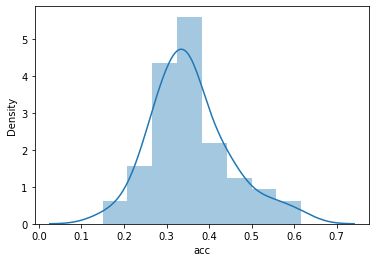

In [39]:
sb.distplot(results["acc"])

In [95]:
results[results["subject"].isin({
    'K309', 'K311', 'K312', 
    'K313', 'K315', 'K316', 
    'K321', 'K322', 'K323', 
    'K325', 'K326', 'K327', 
    'K328', 'K332', 'K334', 
    'K335', 'K336', 'K337', 
    'K339', 'K354', 'K358', 
    'K359', 'K360', 'K362', 
    'K365', 'K366', 'K368', 
    'K370', 'K372', 'K373', 
    'K374', 'K375',
})]

subject       acc  components
1     K309  0.616688          16
3     K311  0.507017          20
4     K312  0.361785          31
5     K313  0.439259          10
7     K315  0.553049          13
8     K316  0.351462          25
11    K321  0.224012           1
12    K322  0.349414           9
13    K323  0.327284           7
15    K325  0.270093           4
16    K326  0.149940          23
17    K327  0.360745          27
18    K328  0.307755          28
22    K332  0.316800          31
24    K334  0.288553          14
25    K335  0.450896           9
26    K336  0.357680          28
27    K337  0.261763          15
29    K339  0.364358           2
36    K354  0.422261           9
39    K358  0.579213          30
40    K359  0.359877           4
41    K360  0.347669           5
43    K362  0.315462          24
45    K365  0.389300          25
46    K366  0.446733          10
47    K368  0.266246          15
49    K370  0.364976           4
51    K372  0.356352          27
52    K373  0.312408          31
53    K374  0.480202          23
54    K375  0.523632          25